# Práctica 3  - Andrés Velasco


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
from Multidimensional_Uns_Optimizer import MultidimensionalUnconstrainedOptimizerBase
warnings.filterwarnings("ignore")




---

### 1. Dado los datos del fichero de texto titulado `isometrizacin.txt` determinar los parámetros que ajustan el modelo

$$
y = \frac{\theta_1 \theta_2 (x_2 - x_3)}{1.632 \left(1 + \theta_2 x_1 + \theta_3 x_2 + \theta_4 x_3\right)}
$$





 





#### a) Linealizar el modelo y obtener una estimación inicial de los parámetros

####  Modelo Linealizado

Sea la variable dependiente transformada:

$$
y' = \frac{1}{y}
$$

El modelo lineal propuesto es:

$$
y' = \beta_0 + \beta_1 x'_1 + \beta_2 x'_2 + \beta_3 x'_3 + \beta_4 x'_4 + \varepsilon
$$

donde los coeficientes son:

$$
\begin{aligned}
\beta_1 &= \frac{1.632}{\theta_1 \theta_2} \\
\beta_2 &= \frac{1.632}{\theta_1} \\
\beta_3 &= \frac{1.632 \, \theta_3}{\theta_1 \theta_2} \\
\beta_4 &= \frac{1.632 \, \theta_4}{\theta_1 \theta_2}
\end{aligned}
$$

y las variables independientes transformadas se definen como:

$$
\begin{aligned}
x'_1 &= \frac{1}{x_2 - x_3} \\
x'_2 &= \frac{x_1}{x_2 - x_3} \\
x'_3 &= \frac{x_2}{x_2 - x_3} \\
x'_4 &= \frac{x_3}{x_2 - x_3}
\end{aligned}
$$


In [62]:
df = pd.read_csv("../data/isomerizacion.txt", sep="\s+", header=1, skiprows=6, engine="python")
df.head()

,x1,x2,x3,y
0,205.8,90.9,37.1,3.541
1,404.8,92.9,36.3,2.397
2,209.7,174.9,49.4,6.694
3,401.6,187.2,44.9,4.722
4,224.9,92.7,116.3,0.593


In [63]:
df["x1_p"] = 1 / (df["x2"] - df["x3"])
df["x2_p"] = df["x1"] / (df["x2"] - df["x3"])
df["x3_p"] = df["x2"] / (df["x2"] - df["x3"])
df["x4_p"] = df["x3"] / (df["x2"] - df["x3"])

df["y_p"] = 1 / df["y"]

df.head()

,x1,x2,x3,y,x1_p,x2_p,x3_p,x4_p,y_p
0,205.8,90.9,37.1,3.541,0.018587,3.825279,1.689591,0.689591,0.282406
1,404.8,92.9,36.3,2.397,0.017668,7.151943,1.641343,0.641343,0.417188
2,209.7,174.9,49.4,6.694,0.007968,1.670916,1.393625,0.393625,0.149388
3,401.6,187.2,44.9,4.722,0.007027,2.822207,1.315531,0.315531,0.211775
4,224.9,92.7,116.3,0.593,-0.042373,-9.529661,-3.927966,-4.927966,1.686341


In [101]:
import statsmodels.api as sm

# Matriz de diseño
X = df[['x1_p','x2_p','x3_p','x4_p']]
X = sm.add_constant(X)  # agrega el intercepto
y = df['y_p']

# 1️⃣ OLS
ols_model = sm.OLS(y, X).fit()
print("Betas OLS con statsmodels:")
print(ols_model.params)
print(ols_model.summary())

# 2️⃣ GLS
# Aquí necesitamos la matriz de covarianza de los residuos (Sigma)
resid_ols = ols_model.resid
n = len(resid_ols)
p = X.shape[1]
Sigma = np.outer(resid_ols, resid_ols) / (n - p)
Sigma += 1e-6 * np.eye(Sigma.shape[0])  # regularización

# GLS con statsmodels
gls_model = sm.GLS(y, X, sigma=Sigma).fit()
print("\nBetas GLS con statsmodels:")
print(gls_model.params)
print(gls_model.summary())


Betas OLS con statsmodels:
const     0.387423
x1_p     13.307060
x2_p     -0.082014
x3_p      0.197573
x4_p     -0.189850
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    y_p   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     2.320
Date:                Sun, 26 Oct 2025   Prob (F-statistic):              0.106
Time:                        17:55:26   Log-Likelihood:                -23.679
No. Observations:                  24   AIC:                             55.36
Df Residuals:                      20   BIC:                             60.07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0

In [64]:

matriz_x = df[['x1_p','x2_p','x3_p','x4_p']].values
unos = np.ones((matriz_x.shape[0], 1))
matriz_x = np.hstack((unos, matriz_x))
matriz_y = df['y_p'].values


beta_ols = np.linalg.inv(matriz_x.T @ matriz_x) @ matriz_x.T @ matriz_y
residuos = matriz_y - matriz_x @ beta_ols

Sigma = np.outer(residuos, residuos) / (len(residuos) - matriz_x.shape[1])


Sigma += 1e-6 * np.eye(Sigma.shape[0])

Sigma_inv = np.linalg.inv(Sigma)
beta_gls = np.linalg.inv(matriz_x.T @ Sigma_inv @ matriz_x) @ matriz_x.T @ Sigma_inv @ matriz_y

print("Betas OLS:", beta_ols)
print("Betas GLS:", beta_gls)

Betas OLS: [ 0.35434159 13.3654777  -0.08142467  0.27966768 -0.2452345 ]
Betas GLS: [ 1.23099196 43.11919588 -0.17882448 -0.58060924  0.60446864]


In [105]:
beta_ols[:4]


array([ 0.35434159, 13.3654777 , -0.08142467,  0.27966768])

In [106]:

beta_1_ols, beta_2_ols, beta_3_ols, beta_4_ols = beta_ols[0:4]

theta_1_ols = 1.632 / beta_2_ols
theta_2_ols = 1.632 / (beta_1_ols * theta_1_ols)
theta_3_ols = (beta_3_ols * theta_1_ols * theta_2_ols) / 1.632
theta_4_ols = (beta_4_ols * theta_1_ols * theta_2_ols) / 1.632

print("=== Thetas (OLS) ===")
print("θ₁ =", theta_1_ols)
print("θ₂ =", theta_2_ols)
print("θ₃ =", theta_3_ols)
print("θ₄ =", theta_4_ols)


beta_1_gls, beta_2_gls, beta_3_gls, beta_4_gls = beta_gls[0:4]

theta_1_gls = 1.632 / beta_2_gls
theta_2_gls = 1.632 / (beta_1_gls * theta_1_gls)
theta_3_gls = (beta_3_gls * theta_1_gls * theta_2_gls) / 1.632
theta_4_gls = (beta_4_gls * theta_1_gls * theta_2_gls) / 1.632

print("\n=== Thetas (GLS) ===")
print("θ₁ =", theta_1_gls)
print("θ₂ =", theta_2_gls)
print("θ₃ =", theta_3_gls)
print("θ₄ =", theta_4_gls)


=== Thetas (OLS) ===
θ₁ = 0.12210562436936039
θ₂ = 37.719190084441294
θ₃ = -0.22979144385588754
θ₄ = 0.7892601101900392

=== Thetas (GLS) ===
θ₁ = 0.03784857223199615
θ₂ = 35.02800764131352
θ₃ = -0.14526859693072966
θ₄ = -0.47165964779821645


In [107]:
df['y_ols'] = (
    theta_1_ols * theta_2_ols * ((df['x2'] - df['x3']) / 1.632)
    / (1 + theta_2_ols * df['x1'] + theta_3_ols * df['x2'] + theta_4_ols * df['x3'])
)

df['y_gls'] = (
    theta_1_gls * theta_2_gls * ((df['x2'] - df['x3']) / 1.632)
    / (1 + theta_2_gls * df['x1'] + theta_3_gls * df['x2'] + theta_4_gls * df['x3'])
)

df['error_ols'] = df['y'] - df['y_ols']
df['error_gls'] = df['y'] - df['y_gls']

=== Métricas de error ===

OLS:
  Media                    : 4.044659
  Varianza                 : 9.900506
  Desviación estándar      : 3.146507
  MAE                      : 4.044659
  RMSE                     : 5.124429

GLS:
  Media                    : 4.063095
  Varianza                 : 10.044578
  Desviación estándar      : 3.169318
  MAE                      : 4.063095
  RMSE                     : 5.152991

 El modelo con menor RMSE (mejor ajuste) es: OLS


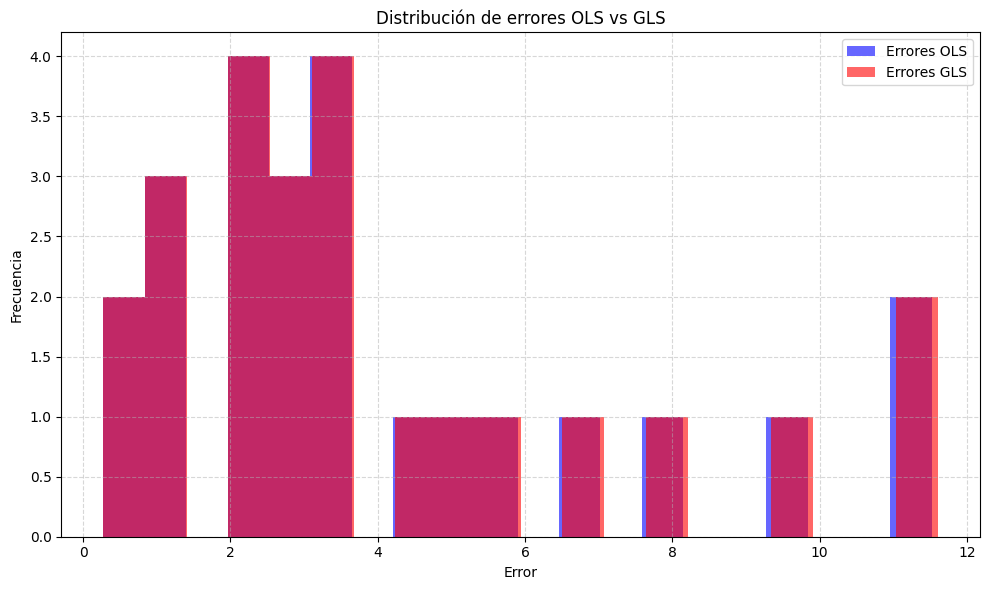

In [108]:

def calcular_metricas(errores):
    return {
        "Media": np.mean(errores),
        "Varianza": np.var(errores),
        "Desviación estándar": np.std(errores),
        "MAE": np.mean(np.abs(errores)),
        "RMSE": np.sqrt(np.mean(errores**2))
    }

metricas_ols = calcular_metricas(df['error_ols'])
metricas_gls = calcular_metricas(df['error_gls'])


print("=== Métricas de error ===")
print("\nOLS:")
for k, v in metricas_ols.items():
    print(f"  {k:25s}: {v:.6f}")

print("\nGLS:")
for k, v in metricas_gls.items():
    print(f"  {k:25s}: {v:.6f}")


mejor_modelo = "GLS" if metricas_gls["RMSE"] < metricas_ols["RMSE"] else "OLS"
print(f"\n El modelo con menor RMSE (mejor ajuste) es: {mejor_modelo}")


plt.figure(figsize=(10, 6))
plt.hist(df['error_ols'], bins=20, alpha=0.6, label='Errores OLS', color='blue')
plt.hist(df['error_gls'], bins=20, alpha=0.6, label='Errores GLS', color='red')

plt.title("Distribución de errores OLS vs GLS")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


---

#### b) Con la estimación inicial anterior, resolver el problema de regresión no lineal minimizando el error cuadrático

In [89]:
def error_cuadratico_medio(theta):
    df = pd.read_csv("../data/isomerizacion.txt", sep="\s+", header=1, skiprows=6, engine="python")
    theta_1 = theta[0]
    theta_2 = theta[1]
    theta_3 = theta[2]
    theta_4 = theta[3]
    df['y_pred'] = theta_1 * theta_2 * ((df['x2']-df['x3'])/1.632) / (1 + theta_2*df['x1'] + theta_3*df['x2'] + theta_4*df['x3'])
    df['error_cuadrado'] = (df['y']-df['y_pred'])**2
    return df['error_cuadrado'].mean()

In [110]:
theta_ols = [theta_1_ols,theta_2_ols,theta_3_ols,theta_4_ols]
theta_gls = [theta_1_gls,theta_2_gls,theta_3_gls,theta_4_gls]
model = MultidimensionalUnconstrainedOptimizerBase(function=error_cuadratico_medio,
        init_value=[100,100,100,100],epsilon=2e-1)
x_k_1, k ,data = model.newton_method(N=np.inf)

[100, 100, 100, 100]
Iter 1: x_k = [100, 100, 100, 100], grad = 0.08570028184306988, x_k+1 = [33.43067621 32.75000383 35.39350574 -2.96667078]
Stopped after 1 iterations. Final approximation: x = [33.43067621 32.75000383 35.39350574 -2.96667078]


In [92]:
df['y_newton'] = (
    x_k_1[0] * x_k_1[1] * ((df['x2'] - df['x3']) / 1.632)
    / (1 + x_k_1[1] * df['x1'] + x_k_1[2] * df['x2'] + x_k_1[3] * df['x3'])
)



---

#### c) Representar los dos ajustes junto a los datos y comparar las dos curvas de regresión

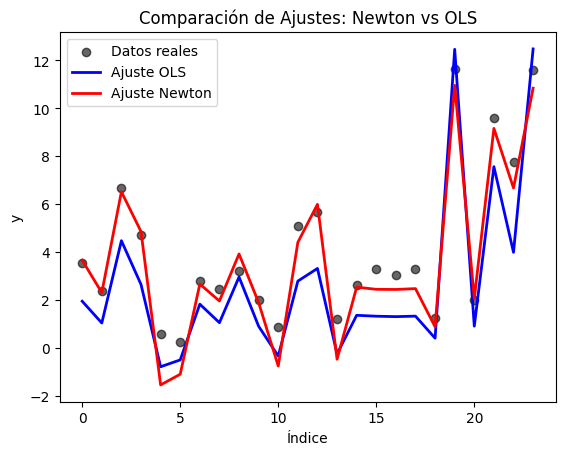

In [112]:


plt.scatter(df.index, df['y'], color='black', label='Datos reales', alpha=0.6)


plt.plot(df.index, df['y_ols']*100, color='blue', label='Ajuste OLS', linewidth=2)


plt.plot(df.index, df['y_newton'], color='red', label='Ajuste Newton', linewidth=2)

plt.xlabel('Índice')
plt.ylabel('y')
plt.title('Comparación de Ajustes: Newton vs OLS')
plt.legend()
plt.show()


## 2. Dados los datos de la siguiente tabla


| x   | 4.5 | 5.0 | 5.1 | 5.3 | 6.2 | 7.1 |
|-----|-----|-----|-----|-----|-----|-----|
| y   | 5.0 | 3.8 | 4.9 | 3.7 | 3.6 | 15.0 |



Determinar la recta de regresión $Y = \alpha + \beta X$ cuando el criterio a minimizar es:


a) La suma del error cuadrático, siendo $\epsilon_i = y_i - \alpha - \beta x_i$ el error de la observación i-ésima con i = 1,2,...,6 

b) La suma del valor absoluto de los errores

c) El máximo del valor absoluto de los errores

Resolver los tres problemas y representar las tres rectas de regresión para ilustrar las diferencias

---

In [ ]:

X = np.array([4.5, 5.0, 5.1, 5.3, 6.2, 7.1])
Y = np.array([5.0, 3.8, 4.9, 3.7, 3.6, 15.0])

def error_cuadratico(beta):
    alpha, b = beta
    y_pred = alpha + b * X
    return np.sum((Y - y_pred)**2)

def error_absoluto(beta):
    alpha, b = beta
    y_pred = alpha + b * X
    return np.sum(np.abs(Y - y_pred))

def error_maximo(beta):
    alpha, b = beta
    y_pred = alpha + b * X
    return np.max(np.abs(Y - y_pred))


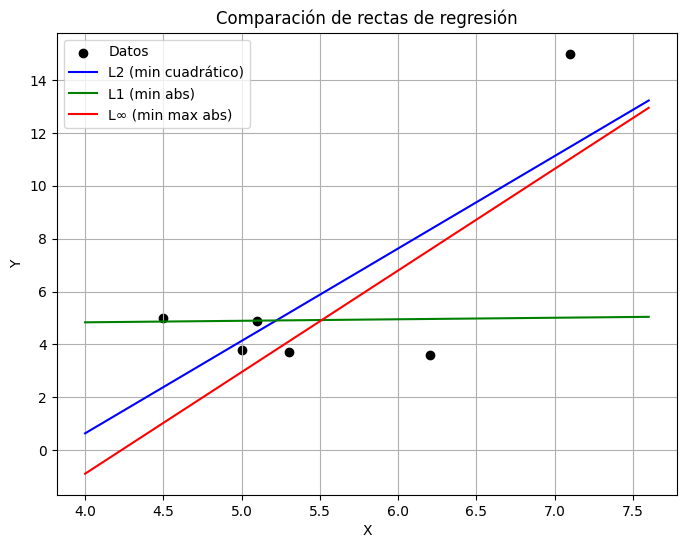

L2 (mínimos cuadrados): alpha = -13.358456973293762 , beta = 3.498516320474777
L1 (mínimos valores absolutos): alpha = 4.605938993131262 , beta = 0.05765902048307479
L∞ (mínimo máximo error): alpha = -16.276919073995536 , beta = 3.8461535305659487


In [ ]:



b_L2 = np.cov(X, Y, bias=True)[0,1] / np.var(X, ddof=0)
alpha_L2 = np.mean(Y) - b_L2 * np.mean(X)

res_L1 = minimize(error_absoluto, [0,0], method='Powell')
alpha_L1, b_L1 = res_L1.x


res_Linf = minimize(error_maximo, [0,0], method='Nelder-Mead')
alpha_Linf, b_Linf = res_Linf.x


plt.figure(figsize=(8,6))
plt.scatter(X, Y, color='black', label='Datos')

x_line = np.linspace(min(X)-0.5, max(X)+0.5, 100)
plt.plot(x_line, alpha_L2 + b_L2 * x_line, label='L2 (min cuadrático)', color='blue')
plt.plot(x_line, alpha_L1 + b_L1 * x_line, label='L1 (min abs)', color='green')
plt.plot(x_line, alpha_Linf + b_Linf * x_line, label='L∞ (min max abs)', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Comparación de rectas de regresión')
plt.legend()
plt.grid(True)
plt.show()


print("L2 (mínimos cuadrados): alpha =", alpha_L2, ", beta =", b_L2)
print("L1 (mínimos valores absolutos): alpha =", alpha_L1, ", beta =", b_L1)
print("L∞ (mínimo máximo error): alpha =", alpha_Linf, ", beta =", b_Linf)
